In [1]:
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2


In [2]:
#insert test image here
test_image_path="/content/drive/MyDrive/Final_project/images/umbc_zipcode.png"

In [3]:
paths={"i":test_image_path,"m":"/content/drive/MyDrive/Final_project/Handwriting.model"}

In [4]:
model=load_model(paths["m"])

In [5]:
image = cv2.imread(paths["i"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

In [6]:
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]


In [7]:
chars = []

In [8]:
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)

	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape

		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)

		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=32)

		# re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)

		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))

		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)

		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))

In [9]:
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")


In [10]:
preds = model.predict(chars)

In [11]:
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]


In [12]:
from google.colab.patches import cv2_imshow

[INFO] 1 - 53.88%
[INFO] 2 - 96.78%
[INFO] M - 88.70%
[INFO] 1 - 99.98%
[INFO] B - 97.38%
[INFO] 2 - 94.07%
[INFO] C - 92.97%
[INFO] 5 - 89.74%
[INFO] 0 - 80.97%


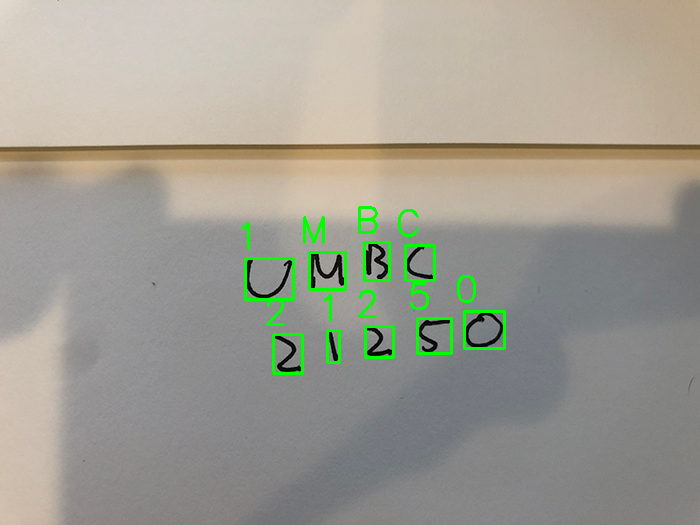

-1

In [13]:
for (pred, (x, y, w, h)) in zip(preds, boxes):
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
	i = np.argmax(pred)
	prob = pred[i]
	label = labelNames[i]

	# draw the prediction on the image
	print("[INFO] {} - {:.2f}%".format(label, prob * 100))
	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
	cv2.putText(image, label, (x - 10, y - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

	# show the image
cv2_imshow(image)
cv2.waitKey(0)